# 实验三： 使用SARSA、Q-learning解决悬崖寻路问题与Deep Q-Learning强化学习算法

**姓名：** 

龙硕

**学号：** 

21281165

## 实验目的

* 分别利用 SARSA 算法和 Q-learning 算法寻找悬崖寻路问题中的最优策略；
* 掌握 SARSA、Q-learning 算法的区别及其核心环节。
* 在 <a  href ="https://www.gymlibrary.ml/">OpenAI Gym</a> 的 CartPole-v0 任务上训练深度Q网络(DQN)；
* 掌握 Deep Q-Learning 算法，体会其与实验三中 Q-learning 的区别与联系。

## 一. 使用SARSA、Q-learning解决悬崖寻路问题

## 1. SARSA、Q-learning 算法流程

### Sarsa:  An on-policy TD control algorithm

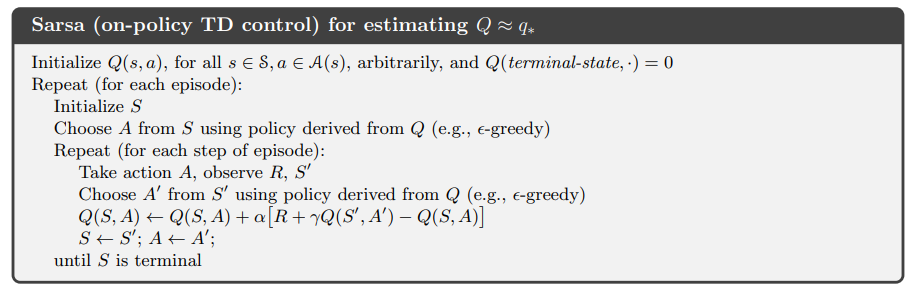

### Q-learning: An off-policy TD control algorithm

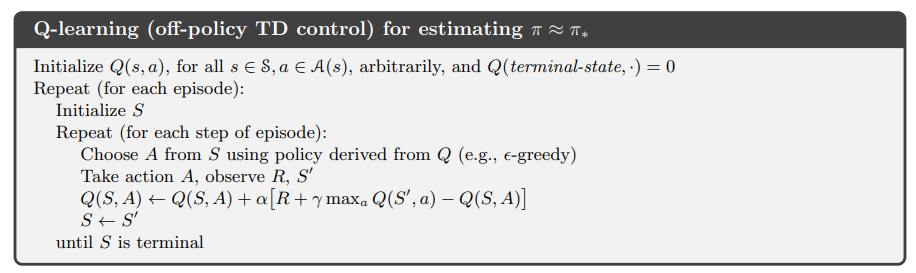

## 2. 环境介绍

该环境名叫悬崖寻路问题，是指在一个4 x 12的网格中，智能体以网格的左下角位置为起点，以网格的下角位置为终点，目标是移动智能体到达终点位置，智能体每次可以在上、下、左、右这4个方向中移动一步，每移动一步会得到-1单位的奖励。

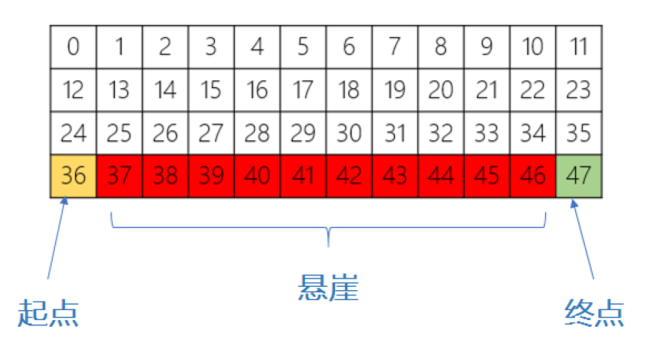

如图，红色部分表示悬崖，数字代表智能体能够观测到的位置信息，即observation，总共会有0-47等48个不同的值，智能体再移动中会有以下限制：

* 智能体不能移出网格，如果智能体想执行某个动作移出网格，那么这一步智能体不会移动，但是这个操作依然会得到-1单位的奖励

* 如果智能体“掉入悬崖” ，会立即回到起点位置，并得到-100单位的奖励

* 当智能体移动到终点时，该回合结束，该回合总奖励为各步奖励之和

实际的仿真界面如下：

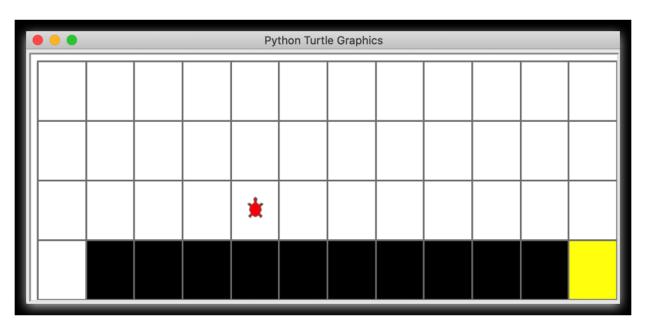

由于从起点到终点最少需要**13**步，每步得到 **-1** 的reward，因此最佳训练算法下，每个episode下reward总和应该为 **-13**。所以我们的目标也是要通过RL训练出一个模型，使得该模型能在测试中一个episode的reward能够接近于 **-13** 左右。

## 3. RL任务训练

### 3.1 本次实验所需要引入的包

In [1]:
import numpy as np
import math
import torch
from collections import defaultdict
import gym
import turtle
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

如果缺少哪个，直接用以下命令安装即可

```python
pip install (缺失包的名称)

```

### 3.2. 环境创建初始化

In [2]:
class CliffWalkingWapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.t = None
        self.unit = 50
        self.max_x = 12
        self.max_y = 4

    def draw_x_line(self, y, x0, x1, color='gray'):
        assert x1 > x0
        self.t.color(color)
        self.t.setheading(0)
        self.t.up()
        self.t.goto(x0, y)
        self.t.down()
        self.t.forward(x1 - x0)

    def draw_y_line(self, x, y0, y1, color='gray'):
        assert y1 > y0
        self.t.color(color)
        self.t.setheading(90)
        self.t.up()
        self.t.goto(x, y0)
        self.t.down()
        self.t.forward(y1 - y0)

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for i in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for _ in range(2):
                self.t.forward(self.max_x * self.unit)
                self.t.left(90)
                self.t.forward(self.max_y * self.unit)
                self.t.left(90)
            for i in range(1, self.max_y):
                self.draw_x_line(
                    y=i * self.unit, x0=0, x1=self.max_x * self.unit)
            for i in range(1, self.max_x):
                self.draw_y_line(
                    x=i * self.unit, y0=0, y1=self.max_y * self.unit)

            for i in range(1, self.max_x - 1):
                self.draw_box(i, 0, 'black')
            self.draw_box(self.max_x - 1, 0, 'yellow')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)

### 3.3 画出结果曲线所需要的工具定义

In [3]:
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth

    Args:
        data (List):输入数据
        weight (Float): 平滑权重，处于0-1之间，数值越高说明越平滑，一般取0.9

    Returns:
        smoothed (List): 平滑后的数据
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title("learning curve on {} of {} for {}".format(
        cfg.device, cfg.algo_name, cfg.env_name))
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()

## 3.4 SARSA

### 3.4.1 相关参数设定

In [4]:
parser = argparse.ArgumentParser(description="hyperparameters") 
parser.add_argument('--algo_name',default='Sarsa',type=str,help="name of algorithm")# 算法名称
parser.add_argument('--env_name',default='CliffWalking-v0',type=str,help="name of environment")
parser.add_argument('--train_eps',default=400,type=int,help="episodes of training") # 训练的回合数
parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing") # 测试的回合数
parser.add_argument('--gamma',default=0.90,type=float,help="discounted factor") # 折扣因子
parser.add_argument('--epsilon',default=0.3,type=float,help="initial value of epsilon") #  e-greedy策略中初始epsilon
parser.add_argument('--lr',default=0.1,type=float,help="learning rate")
parser.add_argument('--device',default='cpu',type=str,help="cpu or cuda")
parser.add_argument('--seed',default=123,type=int,help="random seed")
cfg = parser.parse_args([])

### 3.4.2 SARSA 主要代码框架

In [5]:
class Sarsa(object):
    def __init__(self,
                 n_actions,cfg):
        self.n_actions = n_actions  
        self.lr = cfg.lr  
        self.gamma = cfg.gamma  
        self.sample_count = 0 
        self.epsilon = cfg.epsilon
        self.Q  = defaultdict(lambda: np.zeros(n_actions)) # Q table
    def sample(self, state):
        self.sample_count += 1
        best_action = np.argmax(self.Q[state])
        action_probs = np.ones(self.n_actions, dtype=float) * self.epsilon / self.n_actions
        action_probs[best_action] += (1.0 - self.epsilon)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        return action
    def predict(self,state):
        return np.argmax(self.Q[state])
    def update(self, state, action, reward, next_state, next_action,done):
        # 获得当前预测Q值
        Q_predict = self.Q[state][action]
        if done:
            Q_target = reward  # 终止状态
        else: 
            #与 Q-learning不同，Sarsa是拿下一步动作对应的Q值去更新
            Q_target = reward + self.gamma * self.Q[next_state][next_action] 
            
        self.Q[state][action] += self.lr * (Q_target - Q_predict) 

In [6]:
def env_agent_config(cfg,seed=1):
    '''创建环境和智能体
    Args:
        cfg ([type]): [description]
        seed (int, optional): 随机种子. Defaults to 1.
    Returns:
        env [type]: 环境
        agent : 智能体
    '''    
    env = gym.make(cfg.env_name)  
    env = CliffWalkingWapper(env)
    env.seed(seed) # 设置随机种子
    n_states = env.observation_space.n # 状态维度
    n_actions = env.action_space.n # 动作维度
    print(f"状态数：{n_states}，动作数：{n_actions}")
    agent = Sarsa(n_actions,cfg)
    return env,agent

In [7]:
env, agent = env_agent_config(cfg)

状态数：48，动作数：4


### 3.4.3 开始训练

In [8]:
print('开始训练！')
print(f'环境:{cfg.env_name}, 算法:{cfg.algo_name}, 设备:{cfg.device}')
train_rewards = []  # 记录奖励
for i_ep in range(cfg.train_eps):
    ep_reward = 0  # 记录每个回合的奖励
    state = env.reset()  # 重置环境,即开始新的回合
    action = agent.sample(state)
    while True:
        action = agent.sample(state)  # 根据算法采样一个动作
        next_state, reward, done, _ = env.step(action)  # 与环境进行一次动作交互
        next_action = agent.sample(next_state)
        agent.update(state, action, reward, next_state, next_action,done) # 算法更新
        state = next_state # 更新状态
        action = next_action
        ep_reward += reward
        if done:
            break
    train_rewards.append(ep_reward)
    print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.1f}，Epsilon：{agent.epsilon}")
print('完成训练！')
    

开始训练！
环境:CliffWalking-v0, 算法:Sarsa, 设备:cpu
回合：1/400，奖励：-1781.0，Epsilon：0.3
回合：2/400，奖励：-1906.0，Epsilon：0.3
回合：3/400，奖励：-1536.0，Epsilon：0.3
回合：4/400，奖励：-898.0，Epsilon：0.3
回合：5/400，奖励：-748.0，Epsilon：0.3
回合：6/400，奖励：-79.0，Epsilon：0.3
回合：7/400，奖励：-107.0，Epsilon：0.3
回合：8/400，奖励：-558.0，Epsilon：0.3
回合：9/400，奖励：-1237.0，Epsilon：0.3
回合：10/400，奖励：-578.0，Epsilon：0.3
回合：11/400，奖励：-515.0，Epsilon：0.3
回合：12/400，奖励：-292.0，Epsilon：0.3
回合：13/400，奖励：-183.0，Epsilon：0.3
回合：14/400，奖励：-112.0，Epsilon：0.3
回合：15/400，奖励：-184.0，Epsilon：0.3
回合：16/400，奖励：-52.0，Epsilon：0.3
回合：17/400，奖励：-60.0，Epsilon：0.3
回合：18/400，奖励：-56.0，Epsilon：0.3
回合：19/400，奖励：-77.0，Epsilon：0.3
回合：20/400，奖励：-612.0，Epsilon：0.3
回合：21/400，奖励：-44.0，Epsilon：0.3
回合：22/400，奖励：-240.0，Epsilon：0.3
回合：23/400，奖励：-168.0，Epsilon：0.3
回合：24/400，奖励：-198.0，Epsilon：0.3
回合：25/400，奖励：-47.0，Epsilon：0.3
回合：26/400，奖励：-48.0，Epsilon：0.3
回合：27/400，奖励：-184.0，Epsilon：0.3
回合：28/400，奖励：-69.0，Epsilon：0.3
回合：29/400，奖励：-151.0，Epsilon：0.3
回合：30/400，奖励：-158.0，Epsilon：0.3
回合：31/400，奖

回合：300/400，奖励：-127.0，Epsilon：0.3
回合：301/400，奖励：-32.0，Epsilon：0.3
回合：302/400，奖励：-28.0，Epsilon：0.3
回合：303/400，奖励：-126.0，Epsilon：0.3
回合：304/400，奖励：-33.0，Epsilon：0.3
回合：305/400，奖励：-149.0，Epsilon：0.3
回合：306/400，奖励：-129.0，Epsilon：0.3
回合：307/400，奖励：-30.0，Epsilon：0.3
回合：308/400，奖励：-24.0，Epsilon：0.3
回合：309/400，奖励：-152.0，Epsilon：0.3
回合：310/400，奖励：-33.0，Epsilon：0.3
回合：311/400，奖励：-29.0，Epsilon：0.3
回合：312/400，奖励：-22.0，Epsilon：0.3
回合：313/400，奖励：-23.0，Epsilon：0.3
回合：314/400，奖励：-140.0，Epsilon：0.3
回合：315/400，奖励：-20.0，Epsilon：0.3
回合：316/400，奖励：-21.0，Epsilon：0.3
回合：317/400，奖励：-140.0，Epsilon：0.3
回合：318/400，奖励：-126.0，Epsilon：0.3
回合：319/400，奖励：-25.0，Epsilon：0.3
回合：320/400，奖励：-27.0，Epsilon：0.3
回合：321/400，奖励：-22.0，Epsilon：0.3
回合：322/400，奖励：-21.0，Epsilon：0.3
回合：323/400，奖励：-28.0，Epsilon：0.3
回合：324/400，奖励：-23.0，Epsilon：0.3
回合：325/400，奖励：-19.0，Epsilon：0.3
回合：326/400，奖励：-20.0，Epsilon：0.3
回合：327/400，奖励：-20.0，Epsilon：0.3
回合：328/400，奖励：-23.0，Epsilon：0.3
回合：329/400，奖励：-31.0，Epsilon：0.3
回合：330/400，奖励：-132.0，Epsilon：0.3

### 3.4.4 画出训练结果图

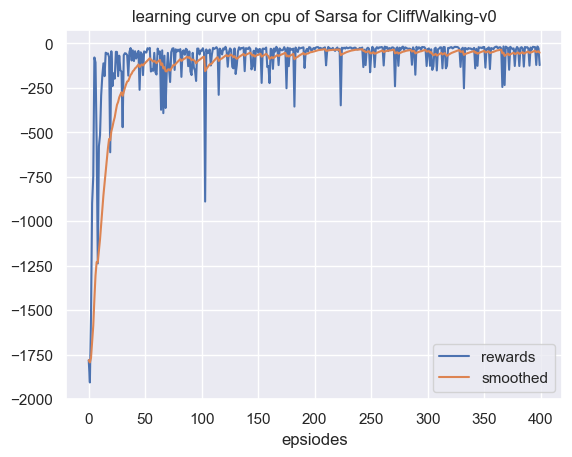

In [9]:
plot_rewards(train_rewards, cfg, tag="train")  

### 3.4.5 开始测试

In [10]:
print('开始测试！')
print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
test_rewards = []  # 记录所有回合的奖励
for i_ep in range(cfg.test_eps):
    ep_reward = 0  # 记录每个episode的reward
    state = env.reset()  # 重置环境, 重新开一局（即开始新的一个回合）
    while True:
        action = agent.predict(state)  # 根据算法选择一个动作
        next_state, reward, done, _ = env.step(action)  # 与环境进行一次交互
        state = next_state  # 更新状态
        ep_reward += reward
        env.render() #windows 平台的同学和Linux有外界显示器的，可以尝试渲染
        if done:
            break
    test_rewards.append(ep_reward)
    print(f"回合数：{i_ep+1}/{cfg.test_eps}, 奖励：{ep_reward:.1f}")
print('完成测试！')

开始测试！
环境：CliffWalking-v0, 算法：Sarsa, 设备：cpu
回合数：1/20, 奖励：-17.0
回合数：2/20, 奖励：-17.0
回合数：3/20, 奖励：-17.0
回合数：4/20, 奖励：-17.0
回合数：5/20, 奖励：-17.0
回合数：6/20, 奖励：-17.0
回合数：7/20, 奖励：-17.0
回合数：8/20, 奖励：-17.0
回合数：9/20, 奖励：-17.0
回合数：10/20, 奖励：-17.0
回合数：11/20, 奖励：-17.0
回合数：12/20, 奖励：-17.0
回合数：13/20, 奖励：-17.0
回合数：14/20, 奖励：-17.0
回合数：15/20, 奖励：-17.0
回合数：16/20, 奖励：-17.0
回合数：17/20, 奖励：-17.0
回合数：18/20, 奖励：-17.0
回合数：19/20, 奖励：-17.0
回合数：20/20, 奖励：-17.0
完成测试！


### 3.4.6 画出测试结果图

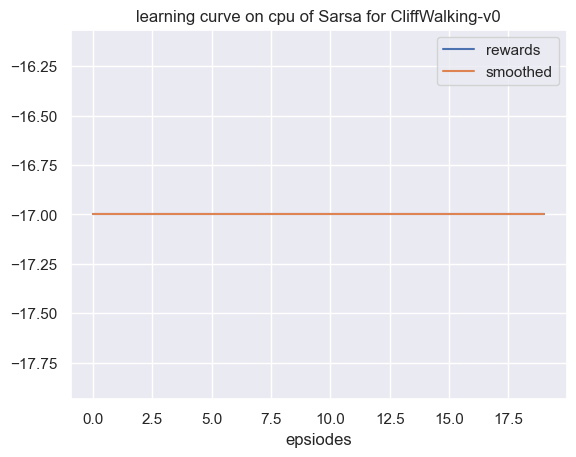

In [11]:
plot_rewards(test_rewards, cfg, tag="train")  

## 3.5 Q-Learning

### 3.5.1 相关参数设定

In [12]:
parser = argparse.ArgumentParser(description="hyperparameters") 
parser.add_argument('--algo_name',default='Q-learning',type=str,help="name of algorithm")
parser.add_argument('--env_name',default='CliffWalking-v0',type=str,help="name of environment")
parser.add_argument('--train_eps',default=400,type=int,help="episodes of training") # 训练的回合数
parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing") # 测试的回合数
parser.add_argument('--gamma',default=0.90,type=float,help="discounted factor") # 折扣因子
parser.add_argument('--epsilon',default=0.3,type=float,help="initial value of epsilon") #  e-greedy策略中初始epsilon
parser.add_argument('--lr',default=0.1,type=float,help="learning rate")
parser.add_argument('--device',default='cpu',type=str,help="cpu or cuda")
parser.add_argument('--seed',default=123,type=int,help="random seed")
cfg = parser.parse_args([])

### 3.5.2 QLearning 主要代码框架

In [13]:
class QLearning(object):
    def __init__(self,n_states,
                 n_actions,cfg):
        self.n_actions = n_actions 
        self.lr = cfg.lr  # 学习率
        self.gamma = cfg.gamma  
        self.epsilon = cfg.epsilon
        self.sample_count = 0  
        self.Q_table  = defaultdict(lambda: np.zeros(n_actions)) # 用嵌套字典存放状态->动作->状态-动作值（Q值）的映射，即Q表
    def sample(self, state):
        ''' 采样动作，训练时用
        '''
        self.sample_count += 1
        # e-greedy 策略
        if np.random.uniform(0, 1) > self.epsilon:
            # 选择Q(s,a)最大对应的动作， 通过查询Q表，选取在当前状态下Q值最大的动作
            action = np.argmax(self.Q_table[str(state)])
            
        else:
            # 随机选择动作
            action = np.random.choice(self.n_actions)
            
            
        return action
    def predict(self,state):
        ''' 预测或选择动作，测试时用
        '''
        action = np.argmax(self.Q_table[str(state)])
        return action
    def update(self, state, action, reward, next_state, done): 
        '''
        基于采样得到的历史数据更新Q表
        '''
        Q_predict = self.Q_table[str(state)][action] # 获得当前预测Q值
        if done: # 终止状态
            Q_target = reward
        else:
            # Q-learning是拿下一步中奖励最大的动作作为当前Q值的target进行更新
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)])

            
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)

In [14]:
def env_agent_config(cfg,seed=1):
    '''创建环境和智能体
    Args:
        cfg ([type]): [description]
        seed (int, optional): 随机种子. Defaults to 1.
    Returns:
        env [type]: 环境
        agent : 智能体
    '''    
    env = gym.make(cfg.env_name)  
    env = CliffWalkingWapper(env)
    env.seed(seed) # 设置随机种子
    n_states = env.observation_space.n # 状态维度
    n_actions = env.action_space.n # 动作维度
    agent = QLearning(n_states,n_actions,cfg)
    return env,agent

In [15]:
env, agent = env_agent_config(cfg)

### 3.5.3 开始训练

In [16]:
print('开始训练！')
print(f'环境:{cfg.env_name}, 算法:{cfg.algo_name}, 设备:{cfg.device}')
train_rewards = []  # 记录奖励
for i_ep in range(cfg.train_eps):
    ep_reward = 0  # 记录每个回合的奖励
    state = env.reset()  # 重置环境,即开始新的回合
    while True:
        action = agent.sample(state)  # 根据算法采样一个动作
        next_state, reward, done, _ = env.step(action)  # 与环境进行一次动作交互
        agent.update(state, action, reward, next_state, done)  # Q学习算法更新
        state = next_state  # 更新状态
        ep_reward += reward
        if done:
            break
    train_rewards.append(ep_reward)
    print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.1f}，Epsilon：{agent.epsilon}")
print('完成训练！')

开始训练！
环境:CliffWalking-v0, 算法:Q-learning, 设备:cpu
回合：1/400，奖励：-2286.0，Epsilon：0.3
回合：2/400，奖励：-2676.0，Epsilon：0.3
回合：3/400，奖励：-962.0，Epsilon：0.3
回合：4/400，奖励：-93.0，Epsilon：0.3
回合：5/400，奖励：-778.0，Epsilon：0.3
回合：6/400，奖励：-856.0，Epsilon：0.3
回合：7/400，奖励：-1287.0，Epsilon：0.3
回合：8/400，奖励：-166.0，Epsilon：0.3
回合：9/400，奖励：-1436.0，Epsilon：0.3
回合：10/400，奖励：-202.0，Epsilon：0.3
回合：11/400，奖励：-228.0，Epsilon：0.3
回合：12/400，奖励：-208.0，Epsilon：0.3
回合：13/400，奖励：-177.0，Epsilon：0.3
回合：14/400，奖励：-322.0，Epsilon：0.3
回合：15/400，奖励：-491.0，Epsilon：0.3
回合：16/400，奖励：-1462.0，Epsilon：0.3
回合：17/400，奖励：-281.0，Epsilon：0.3
回合：18/400，奖励：-562.0，Epsilon：0.3
回合：19/400，奖励：-170.0，Epsilon：0.3
回合：20/400，奖励：-514.0，Epsilon：0.3
回合：21/400，奖励：-873.0，Epsilon：0.3
回合：22/400，奖励：-46.0，Epsilon：0.3
回合：23/400，奖励：-185.0，Epsilon：0.3
回合：24/400，奖励：-406.0，Epsilon：0.3
回合：25/400，奖励：-52.0，Epsilon：0.3
回合：26/400，奖励：-497.0，Epsilon：0.3
回合：27/400，奖励：-502.0，Epsilon：0.3
回合：28/400，奖励：-58.0，Epsilon：0.3
回合：29/400，奖励：-305.0，Epsilon：0.3
回合：30/400，奖励：-189.0，Epsilon：0.3


回合：305/400，奖励：-351.0，Epsilon：0.3
回合：306/400，奖励：-121.0，Epsilon：0.3
回合：307/400，奖励：-17.0，Epsilon：0.3
回合：308/400，奖励：-765.0，Epsilon：0.3
回合：309/400，奖励：-339.0，Epsilon：0.3
回合：310/400，奖励：-128.0，Epsilon：0.3
回合：311/400，奖励：-536.0，Epsilon：0.3
回合：312/400，奖励：-13.0，Epsilon：0.3
回合：313/400，奖励：-17.0，Epsilon：0.3
回合：314/400，奖励：-17.0，Epsilon：0.3
回合：315/400，奖励：-129.0，Epsilon：0.3
回合：316/400，奖励：-125.0，Epsilon：0.3
回合：317/400，奖励：-233.0，Epsilon：0.3
回合：318/400，奖励：-17.0，Epsilon：0.3
回合：319/400，奖励：-17.0，Epsilon：0.3
回合：320/400，奖励：-445.0，Epsilon：0.3
回合：321/400，奖励：-560.0，Epsilon：0.3
回合：322/400，奖励：-595.0，Epsilon：0.3
回合：323/400，奖励：-344.0，Epsilon：0.3
回合：324/400，奖励：-130.0，Epsilon：0.3
回合：325/400，奖励：-17.0，Epsilon：0.3
回合：326/400，奖励：-123.0，Epsilon：0.3
回合：327/400，奖励：-353.0，Epsilon：0.3
回合：328/400，奖励：-125.0，Epsilon：0.3
回合：329/400，奖励：-466.0，Epsilon：0.3
回合：330/400，奖励：-144.0，Epsilon：0.3
回合：331/400，奖励：-125.0，Epsilon：0.3
回合：332/400，奖励：-29.0，Epsilon：0.3
回合：333/400，奖励：-19.0，Epsilon：0.3
回合：334/400，奖励：-120.0，Epsilon：0.3
回合：335/400，奖励：-335.

### 3.5.4 画出训练结果

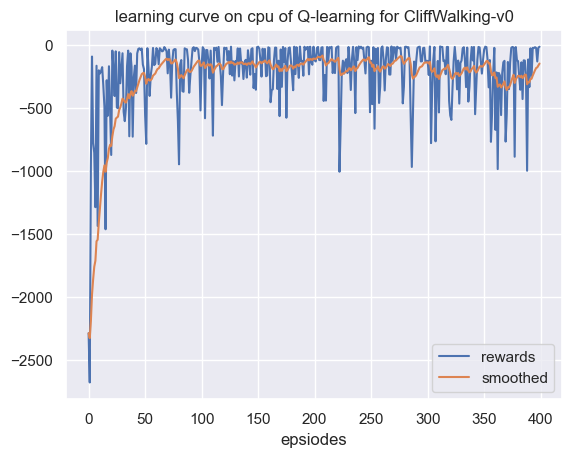

In [17]:
plot_rewards(train_rewards, cfg, tag="train")

### 3.5.5 开始测试

In [18]:
print('开始测试！')
print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
test_rewards = []  # 记录所有回合的奖励
for i_ep in range(cfg.test_eps):
    ep_reward = 0  # 记录每个episode的reward
    state = env.reset()  # 重置环境, 重新开一局（即开始新的一个回合）
    print(i_ep)
    while True:
        action = agent.predict(state)  # 根据算法选择一个动作
        next_state, reward, done, _ = env.step(action)  # 与环境进行一个交互
#         env.render() #windows 平台的同学和Linux有外界显示器的，可以尝试渲染
        state = next_state  # 更新状态
        ep_reward += reward
        if done:
            break
    test_rewards.append(ep_reward)
    print(f"回合数：{i_ep+1}/{cfg.test_eps}, 奖励：{ep_reward:.1f}")
print('完成测试！')

开始测试！
环境：CliffWalking-v0, 算法：Q-learning, 设备：cpu
0
回合数：1/20, 奖励：-13.0
1
回合数：2/20, 奖励：-13.0
2
回合数：3/20, 奖励：-13.0
3
回合数：4/20, 奖励：-13.0
4
回合数：5/20, 奖励：-13.0
5
回合数：6/20, 奖励：-13.0
6
回合数：7/20, 奖励：-13.0
7
回合数：8/20, 奖励：-13.0
8
回合数：9/20, 奖励：-13.0
9
回合数：10/20, 奖励：-13.0
10
回合数：11/20, 奖励：-13.0
11
回合数：12/20, 奖励：-13.0
12
回合数：13/20, 奖励：-13.0
13
回合数：14/20, 奖励：-13.0
14
回合数：15/20, 奖励：-13.0
15
回合数：16/20, 奖励：-13.0
16
回合数：17/20, 奖励：-13.0
17
回合数：18/20, 奖励：-13.0
18
回合数：19/20, 奖励：-13.0
19
回合数：20/20, 奖励：-13.0
完成测试！


### 3.5.6 画出测试结果

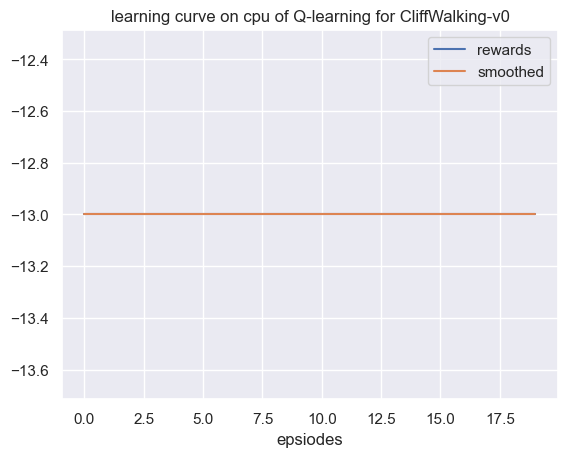

In [19]:
plot_rewards(test_rewards, cfg, tag="test")  # 画出结果

## 4. 问题

**Q1&2：** Q-learning 和 SARSA的区别？从训练结果中你有什么样的发现？为什么训练结果会有这些不同？为什么在测试阶段的最终结果有所差异？

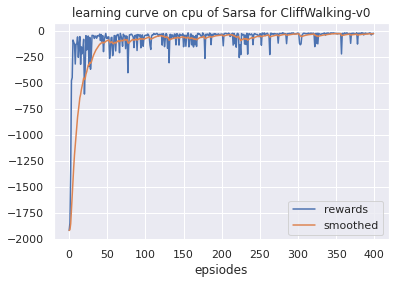

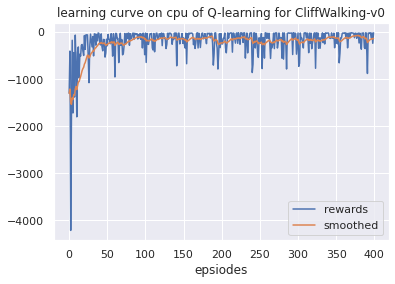

**Q3：** ε的大小对于实验结果的影响？你觉得如何调整较为合适？

**Q4：** 折扣因子的大小是否会对训练结果产生影响？为什么会出现这种影响？

## 二. Deep Q-Learning 强化学习算法

## 1. Deep Q-Learning 算法介绍

强化学习的目标是训练一种策略，试图最大化折扣、累积奖励: **Return**

$$
R =\sum_{t=0}^{\infty} \gamma^{t} r_{t}
$$
 <br />

<center> $R$: 累计奖励； $\gamma$: 折扣因子 ； $r_{t}$: 在$t$时刻的即时奖励


### 主要思想

<br >假如我们有一个动作-价值函数（以下简称为$Q$函数） $Q^{*}(s,a):$ 状态 $\times$ 动作 $\rightarrow \mathbb{R}$ , 可以准确地给出在当前状态**s**下采取动作**a**所带来的累计奖励的估计值是多少, 那么基于此我们可以很容易的得到其对应的最优行为策略$\pi$(policy)

$$\pi^{*}(s)=\underset{a}{\operatorname{argmax}} Q^{*}(s, a)$$

然而，基于我们对所处环境了解的局限性，我们往往很难得到这个最优的$Q^{*}$。但神经网络可以逼近任何一个函数，我们可以训练一个神经网络，通过贝尔曼算子，使其不断地迭代更新并获得最优的$Q^{*}$. 根据贝尔曼方程，我们有:

$$Q^{\pi}(s, a)=r+\gamma Q^{\pi}\left(s^{\prime}, \pi\left(s^{\prime}\right)\right)$$

等式两边的差值被称为**TD-error**(temporal differences error)

$$\delta=Q(s, a)-\left(r+\gamma \max _{a} Q\left(s^{\prime}, a\right)\right)$$

我们的目标，就是在前后两次的更新Q值过程中，缩小TD-error的差距

### 算法框架

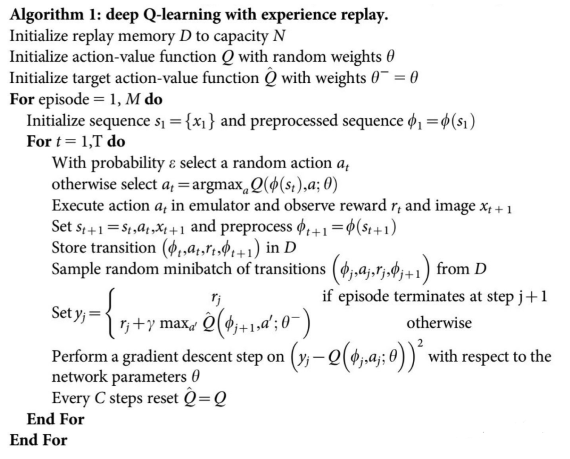

## 2. 实验环境

Cart Pole，即车杆游戏。游戏里面有一个小车，上有竖着一根杆子，每次重置后的初始状态会有所不同。小车需要左右移动来保持杆子竖直，为了保证游戏继续进行需要满足以下两个条件：

* 杆子倾斜的角度 ${\theta}$ 不能大于15°
* 小车移动的位置 ${x}$ 需保持在一定范围（中间到两边各2.4个单位长度）


动作（action）：
* 左移（0）
* 右移（1）

状态变量（state variables）：

* ${x}$：小车在轨道上的位置（position of the cart on the track）
* ${\theta}$：杆子与竖直方向的夹角（angle of the pole with the vertical）
* ${\dot{x}}$ 小车速度（cart velocity）
* ${\dot{\theta}}$ 角度变化率（rate of change of the angle）

游戏奖励（reward）：
* 在gym的Cart Pole环境（env）里面，左移或者右移小车的action之后，env会返回一个+1的reward。其中CartPole-v0中到达200个reward之后，游戏会结束，而CartPole-v1中则为500。

以下代码显示了初始状态下的取值，每次调用env.reset( )将重新产生一个初始状态。打印出的observation的四个元素分别表示了小车位置、小车速度、杆子夹角及角变化率。

In [20]:
import gym
env = gym.make('CartPole-v0')
observation = env.reset()
print(observation)

[ 0.01128565 -0.01251135  0.04948305  0.01973132]


![cartpole](https://pytorch.org/tutorials/_images/cartpole.gif)

# 3. DQN

### 3.1.1 本次实验所需要引入的包

如有缺少，使用  pip install 命令安装即可

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt
from gym import wrappers
import io
import base64
from tqdm import * 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from IPython import display
from IPython.display import HTML
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### 3.1.2 相关参数初始化

In [22]:
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # 最优选择动作百分比
GAMMA = 0.9                 # 奖励递减参数
TARGET_REPLACE_ITER = 100   # Q 现实网络的更新频率
MEMORY_CAPACITY = 2000      # 记忆库大小

env = gym.make('CartPole-v0') # 立杆子游戏
env = env.unwrapped
# env = wrappers.Monitor(env, "./gym-results", force=True)

N_ACTIONS = env.action_space.n  # 杆子能做的动作

N_STATES = env.observation_space.shape[0]   # 杆子能获取的环境信息数

ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape

### 3.1.3 渲染所需要的方法

In [23]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title(" CartPole-v0 | Step: %d %s" % (step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

### 3.1.4 神经网络定义

In [24]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

### 3.1.5 DQN

In [25]:
class DQN(object):
    def __init__(self):
        
        # 建立 target net 和 eval net 还有 memory
        self.eval_net = Net()
        self.target_net = Net()
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))
        self.memory_counter = 0
        self.learn_step_counter = 0
        self.optimizer = optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

        
    def choose_action(self, x):
        # 根据环境观测值选择动作的机制
        state = torch.unsqueeze(torch.FloatTensor(x), 0)
        if np.random.uniform() < EPSILON:
            actions_value = self.eval_net.forward(state)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0]
        else:
            action = np.random.randint(0, N_ACTIONS)
        return action


    def store_transition(self, s, a, r, s_):
        # 存储记忆
        transition = np.hstack((s, [a, r], s_))
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target 网络更新
        # 学习记忆库中的记忆
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        q_eval = self.eval_net(b_s).gather(1, b_a)
        q_next = self.target_net(b_s_).detach()
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### 3.1.6 训练

In [26]:
dqn = DQN()

print('\nCollection experience...')
scores = []
for i_episode in range(400):
    s = env.reset() #得到环境的反馈，现在的状态
    ep_r = 0
    step = 0
    print_res = True if i_episode % 50 == 0 else False
    while True:
       # env.render() #环境渲染，可以看到屏幕上的环境
        a = dqn.choose_action(s) #根据dqn来接受现在的状态，得到一个行为
        new_state, reward, done, _ = env.step(a) #根据环境的行为，给出一个反馈
        
#         if print_res: #Linux环境渲染，可以看到屏幕上的环境
#             show_state(env, step)
#         修改 reward, 加快 DQN 快速学习
        x, x_dot, theta, theta_dot = new_state
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        reward = r1 + r2
        
        dqn.store_transition(s,a,reward,new_state) #dqn存储现在的状态，行为，反馈，和环境导引的下一个状态
        
        ep_r += reward
        
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
            if done:
                print('Ep: ', i_episode,
                      '| Ep_r: ', round(ep_r, 2))
        step += 1
        if done:
            break
            
        s = new_state # 现在的状态赋值到下一个状态上去
    scores.append(ep_r)
        
env.close()


Collection experience...
Ep:  204 | Ep_r:  2.86
Ep:  205 | Ep_r:  1.12
Ep:  206 | Ep_r:  7.78
Ep:  207 | Ep_r:  1.92
Ep:  208 | Ep_r:  2.08
Ep:  209 | Ep_r:  2.28
Ep:  210 | Ep_r:  1.62
Ep:  211 | Ep_r:  2.43
Ep:  212 | Ep_r:  0.94
Ep:  213 | Ep_r:  2.6
Ep:  214 | Ep_r:  5.92
Ep:  215 | Ep_r:  3.51
Ep:  216 | Ep_r:  1.23
Ep:  217 | Ep_r:  0.97
Ep:  218 | Ep_r:  1.45
Ep:  219 | Ep_r:  1.44
Ep:  220 | Ep_r:  2.91
Ep:  221 | Ep_r:  2.39
Ep:  222 | Ep_r:  1.86
Ep:  223 | Ep_r:  9.21
Ep:  224 | Ep_r:  9.5
Ep:  225 | Ep_r:  0.68
Ep:  226 | Ep_r:  7.24
Ep:  227 | Ep_r:  5.11
Ep:  228 | Ep_r:  6.59
Ep:  229 | Ep_r:  8.51
Ep:  230 | Ep_r:  3.85
Ep:  231 | Ep_r:  2.18
Ep:  232 | Ep_r:  4.54
Ep:  233 | Ep_r:  9.0
Ep:  234 | Ep_r:  14.91
Ep:  235 | Ep_r:  1.69
Ep:  236 | Ep_r:  8.66
Ep:  237 | Ep_r:  20.77
Ep:  238 | Ep_r:  29.74
Ep:  239 | Ep_r:  25.39
Ep:  240 | Ep_r:  28.71
Ep:  241 | Ep_r:  44.91
Ep:  242 | Ep_r:  16.59
Ep:  243 | Ep_r:  23.78
Ep:  244 | Ep_r:  95.71
Ep:  245 | Ep_r:  44.3
Ep

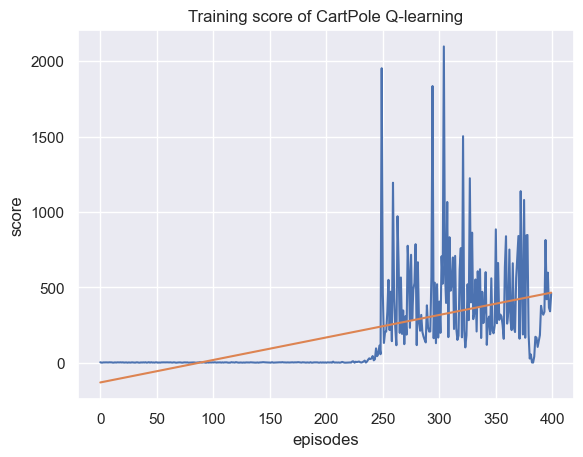

In [27]:
sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole Q-learning')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

## 4. 问题

1. DQN与Q-learning之间的区别和联系？

两者都是为了找到一个最优策略，使得在每个状态下选择的动作能够最大化累积奖励

Q-learning：使用表格（Q表）来存储每个状态-动作对的Q值。这在状态空间和动作空间都比较小时有效，但在高维状态空间中不可行。
DQN：使用神经网络来近似Q值。神经网络接受状态作为输入，输出每个可能动作的Q值。这使得DQN可以处理连续和高维的状态空间。

2. DQN的优缺点？

DQN使用神经网络来近似Q值函数，使其能够处理高维和连续的状态空间，而不像传统Q-learning依赖表格形式的Q表，受限于较小的状态空间。

DQN引入经验重放机制，将代理与环境的交互经验存储在记忆库中，并从中随机抽取小批次用于训练。这打破了数据的时间相关性，提高了样本效率和训练稳定性

3. DQN中用到的两个关键性技巧分别是什么？其作用分别是什么？

经验重放（Experience Replay）
作用：

打破数据相关性：在连续的环境交互中，样本数据之间具有很强的相关性，这可能导致训练不稳定性。通过将代理与环境交互的经验存储在一个经验回放记忆库中，并随机抽取小批次用于训练，可以打破这种相关性，提高训练的稳定性。
提高样本效率：通过经验重放，代理可以在多次使用相同的经验数据来学习，从而更好地利用已有的数据，提高训练的样本效率。
2. 目标网络（Target Network）
作用：

稳定训练：引入目标网络是为了减少训练过程中的波动和发散。目标网络是一个独立的神经网络，其参数定期从评估网络中复制过来，而不是每次更新都更新。这样可以使目标Q值更加稳定，减少了更新过程中的不稳定性。
降低目标Q值的变化：在计算目标Q值时，使用目标网络来生成目标Q值，而不是使用当前的评估网络。这样可以降低目标Q值的变化程度，提高学习的稳定性，避免训练过程中的剧烈波动。

4. gym中还有其他环境可以进行尝试，如果感兴趣可以尝试其他环境验证DQN算法的有效性，并分析对应的结果。（可选）

## 提交形式

* 提交notebook**原始文件**， 即以.ipynb为结尾的文件

* 本次实验notebook的**pdf**


* pdf转换方法：
    1. 在当前页面浏览器右上角选择“打印...”
    2. 目标打印机选择“另存为PDF”，布局选择“纵向”。然后查看预览效果，主要查看是否有代码内容显示不全，若无，则按“保存”即可，否则，继续选择下面的“缩放”，直到预览的结果满意为止，最后点击“保存”即可。